## Setup Environment

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install transformers
! pip install pycaret
! pip install squarify

In [3]:
import numpy as np
import pandas as pd
import pycaret
import nltk, re, string
from string import punctuation
from nltk.corpus import stopwords
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import os
from tqdm import tqdm_notebook
# specify GPU
device = torch.device("cuda")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Set Working Directory
%cd /content/drive/My Drive/Colab Notebooks/DL-Project

/content/drive/My Drive/Colab Notebooks/DL-Project


## Load Dataset

In [5]:
data = pd.read_csv('final_fake_news.csv')
#fake_data = pd.read_csv('Fake.csv')

data['Target'] = 'True'
data.loc[data['label'] == 0, 'Target'] = 'Fake'

#true_data['Target'] = ['True']*len(true_data)
#fake_data['Target'] = ['Fake']*len(fake_data)

data = data.sample(frac=1).reset_index().drop(columns=['index'])


print(data.shape)
data.head()

(39409, 3)


,text,label,Target
0,wow brave veteran confronts ferguson thug stom...,0,Fake
1,maine new jersey end state government shutdown...,1,True
2,cbs minute withhold trump appeal stop attack m...,0,Fake
3,senior north korean diplomat meet un political...,1,True
4,u concerned violence around iraq kirkuk state ...,1,True


In [6]:
# True/Fake to numbers 0/1 (Fake=1)
data['label'] = pd.get_dummies(data.Target)['Fake']

In [7]:
data.head()

,text,label,Target
0,wow brave veteran confronts ferguson thug stom...,1,Fake
1,maine new jersey end state government shutdown...,0,True
2,cbs minute withhold trump appeal stop attack m...,1,Fake
3,senior north korean diplomat meet un political...,0,True
4,u concerned violence around iraq kirkuk state ...,0,True


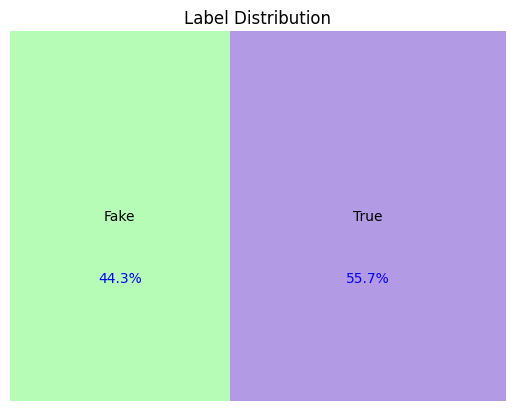

In [8]:
import matplotlib.pyplot as plt
import squarify

label_size = [data['label'].sum(), len(data['label']) - data['label'].sum()]
labels = ['Fake', 'True']
colors = ['#98FB98', '#9370DB']

fig, ax = plt.subplots()
squarify.plot(sizes=label_size, label=labels, color=colors, alpha=0.7, ax=ax)

plt.title('Label Distribution')
plt.axis('off')

for i, rect in enumerate(ax.patches):
    percentage = label_size[i] / sum(label_size) * 100
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_y() + rect.get_height() / 3
    plt.text(x=x, y=y, s=f'{percentage:.1f}%', ha='center', va='center', fontsize=10, color='blue')

plt.show()

In [9]:
# Check if there are null values
if data.isnull().values.any():
    print("There are null values in the dataset.")
else:
    print("There are no null values in the dataset.")

There are no null values in the dataset.


In [10]:
data.head()

,text,label,Target
0,wow brave veteran confronts ferguson thug stom...,1,Fake
1,maine new jersey end state government shutdown...,0,True
2,cbs minute withhold trump appeal stop attack m...,1,Fake
3,senior north korean diplomat meet un political...,0,True
4,u concerned violence around iraq kirkuk state ...,0,True


## Train-test-split

In [11]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [12]:
# Load BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

### Prepare Input Data

Median: 215.0
Mode: 193
Mean: 237.77764083230625
Minimum: 4


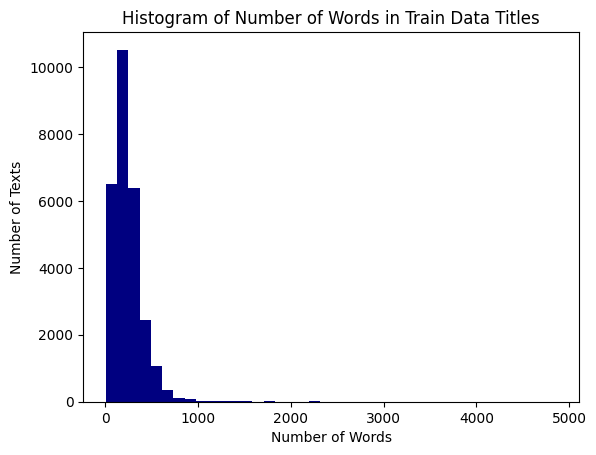

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Calculate the number of words in each title
seq_len = [len(title.split()) for title in train_text]

plt.hist(seq_len, bins=40, color='navy')

plt.xlabel('Number of Words')
plt.ylabel('Number of Texts')
plt.title('Histogram of Number of Words in Train Data Titles')

# Calculate the median
median_value = np.median(seq_len)
print("Median:", median_value)

# Calculate the mode
mode_value = stats.mode(seq_len)
print("Mode:", mode_value.mode[0])

# Calculate the mean
mean_value = np.mean(seq_len)
print("Mean:", mean_value)

# Calculate the minimum
minimum_value = np.min(seq_len)
print("Minimum:", minimum_value)
# Show the plot
plt.show()


In [14]:
# Set max title length
MAX_LENGTH = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

In [15]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [16]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(val_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)


In [17]:
# Freeze the parameters of the pre-trained BERT model
for param in bert.parameters():
    param.requires_grad = False

### Define Model Architecture

### Define Train & Evaluate Function

In [18]:
DROPOUT = .10

# https://arxiv.org/pdf/1910.03474v1.pdf
# idea - benchmark with no fine-tuning

class BERT_Arch_PlusTwoLL(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch_PlusTwoLL, self).__init__()
      self.bert = bert
      #self.dropout = nn.Dropout(DROPOUT)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output'].to(device)

      x = self.fc1(cls_hs).to(device)
      x = self.relu(x).to(device)
      #x = self.dropout(x).to(device)
      x = self.fc2(x).to(device)
      return x

class BERT_ArchPlusOneLLB(nn.Module):
    def __init__(self, bert):
      super(BERT_ArchPlusOneLLB, self).__init__()
      self.bert = bert
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.softmax(x)
      return x

class BERT_ArchPlusOneLLC(nn.Module):
    def __init__(self, bert):
      super(BERT_ArchPlusOneLLC, self).__init__()
      self.bert = bert
      self.softmax = nn.LogSoftmax(dim=1)
      self.fc1 = nn.Linear(768,2)

    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.fc1(cls_hs)
      x = self.softmax(x)
      return x


class BERT_ArchPlusOneLLD(nn.Module): #https://paperswithcode.com/paper/improving-results-on-russian-sentiment
    def __init__(self, bert):
      super(BERT_ArchPlusOneLLD, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(DROPOUT)
      self.fc1 = nn.Linear(768,2)

    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
      x = self.dropout(cls_hs)
      x = self.fc1(cls_hs)
      return x

class BERT_ArchPlusThreeLL(nn.Module):
    def __init__(self, bert):
      super(BERT_ArchPlusThreeLL, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(DROPOUT)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output'].to(device)
      x = self.fc1(cls_hs).to(device)
      x = self.relu(x).to(device)
      x = self.fc2(x).to(device)
      x = self.relu(x).to(device)
      x = self.fc3(x).to(device)
      x = self.relu(x).to(device)
      return x


class BERT_ArchPlusOneLL(nn.Module):
    def __init__(self, bert):
      super(BERT_ArchPlusOneLL, self).__init__()
      self.bert = bert
      self.fc1 = nn.Linear(768,2)

    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output'].to(device)
      x = self.fc1(cls_hs).to(device)
      return x

class BERT_ArchPlusOneLLNotFrozen(nn.Module):
    def __init__(self, bert):
      super(BERT_ArchPlusOneLLNotFrozen, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(DROPOUT)
      self.fc1 = nn.Linear(768,2)

    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output'].to(device)
      x = self.dropout(cls_hs).to(device)
      x = self.fc1(x).to(device)
      return x

class BERT_Arch_PlusTwoLLNotFrozen(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch_PlusTwoLLNotFrozen, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(DROPOUT)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output'].to(device)
      x = self.dropout(cls_hs).to(device)
      x = self.fc1(cls_hs).to(device)
      x = self.relu(x).to(device)
      x = self.dropout(x).to(device)
      x = self.fc2(x).to(device)
      return x

model = BERT_Arch_PlusTwoLL(bert).to(device)
from transformers import AdamW
lr =1e-5
weight_decay = 1e-3
optimizer = AdamW(model.parameters(),
                  lr = lr, weight_decay=weight_decay)
cross_entropy  = nn.CrossEntropyLoss()
epochs = 40

In [19]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)

  return total_loss, avg_loss

def evaluate(dataloader):
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(dataloader):
    if step % 50 == 0 and not step == 0:


      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(dataloader)
  return total_loss, avg_loss

### Model training

In [20]:
def find_accuracy(model, dataloader, device, batch_size):
    # Set the model to eval mode to avoid weights update
    model.eval()
    correct_pred = 0
    with torch.no_grad():
        # Get the progress bar
        progress_bar = tqdm_notebook(dataloader, ascii=True)
        for batch_idx, data in enumerate(progress_bar):
            #print(f"Batch {batch_idx} is evaluating")
            source = data[0].to(device)
            mask = data[1].to(device)
            target = data[2].unsqueeze(1).to(device)
            translation = model(source, mask)
            #translation = translation.mean(1)

            preds = torch.argmax(translation, axis = 1)
            target = target.float()
            #if batch_idx % 50 == 0:
            #    print(target.T)
            #    print(preds)
            correct_items = ((preds == target.T).int()).sum().item()
            #print(correct_items)
            #print(f"cool, in this batch we got {correct_items} correct.")
            correct_pred += correct_items
            progress_bar.set_description_str(
                "Batch: %d, Correct items: %.4f" % ((batch_idx + 1), correct_items))
    #print(f"Calculating accuracy: {correct_pred} / {len(dataloader)} * {batch_size}")
    accuracy = correct_pred / (len(dataloader)*batch_size)
    return accuracy

In [ ]:

best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]
test_losses = []
train_per = []
valid_per = []
train_acc_list = []
valid_acc_list = []
test_per = []
test_acc_list = []

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, avg_train_loss = train()
    valid_loss, avg_valid_loss = evaluate(val_dataloader)
    test_loss, avg_test_loss = evaluate(test_dataloader)
    if valid_loss < best_valid_loss:
        print("Saving model.")
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_weights.pt')

    train_perplexity = np.exp(avg_train_loss)
    val_perplexity = np.exp(avg_valid_loss)
    test_perplexity = np.exp(avg_test_loss)


    acc_train = find_accuracy(model, train_dataloader, device=device, batch_size=batch_size)
    acc_val = find_accuracy(model, val_dataloader, device=device, batch_size=batch_size)
    acc_test = find_accuracy(model, test_dataloader, device=device, batch_size=batch_size)


    train_per.append(train_perplexity)
    valid_per.append(val_perplexity)
    test_per.append(test_perplexity)

    train_acc_list.append(acc_train)
    valid_acc_list.append(acc_val)
    test_acc_list.append(acc_test)

    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)
    test_losses.append(avg_test_loss)


    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTest Loss: {test_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'Training Perplexity: {train_perplexity:.3f}')
    print(f'Test Perplexity: {test_perplexity:.3f}')
    print(f'Validation Perplexity: {val_perplexity:.3f}')
    print(f'Training Accuracy: {acc_train:.3f}')
    print(f'Test Accuracy: {acc_test:.3f}')
    print(f'Validation Accuracy: {acc_val:.3f}')


 Epoch 1 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 525.130

Test Loss: 93.066
Validation Loss: 93.091
Training Perplexity: 1.838
Test Perplexity: 1.654
Validation Perplexity: 1.654
Training Accuracy: 0.892
Test Accuracy: 0.898
Validation Accuracy: 0.899

 Epoch 2 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 399.555

Test Loss: 66.221
Validation Loss: 66.174
Training Perplexity: 1.589
Test Perplexity: 1.430
Validation Perplexity: 1.430
Training Accuracy: 0.901
Test Accuracy: 0.902
Validation Accuracy: 0.905

 Epoch 3 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 312.994

Test Loss: 51.331
Validation Loss: 51.161
Training Perplexity: 1.437
Test Perplexity: 1.320
Validation Perplexity: 1.319
Training Accuracy: 0.910
Test Accuracy: 0.913
Validation Accuracy: 0.914

 Epoch 4 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 261.639

Test Loss: 43.658
Validation Loss: 43.184
Training Perplexity: 1.354
Test Perplexity: 1.266
Validation Perplexity: 1.263
Training Accuracy: 0.920
Test Accuracy: 0.922
Validation Accuracy: 0.926

 Epoch 5 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 233.886

Test Loss: 40.506
Validation Loss: 40.095
Training Perplexity: 1.311
Test Perplexity: 1.245
Validation Perplexity: 1.242
Training Accuracy: 0.914
Test Accuracy: 0.914
Validation Accuracy: 0.917

 Epoch 6 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 218.009

Test Loss: 36.850
Validation Loss: 36.312
Training Perplexity: 1.287
Test Perplexity: 1.220
Validation Perplexity: 1.217
Training Accuracy: 0.923
Test Accuracy: 0.923
Validation Accuracy: 0.925

 Epoch 7 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 210.292

Test Loss: 35.109
Validation Loss: 34.472
Training Perplexity: 1.276
Test Perplexity: 1.209
Validation Perplexity: 1.205
Training Accuracy: 0.924
Test Accuracy: 0.926
Validation Accuracy: 0.928

 Epoch 8 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 200.729

Test Loss: 33.780
Validation Loss: 33.038
Training Perplexity: 1.262
Test Perplexity: 1.200
Validation Perplexity: 1.196
Training Accuracy: 0.927
Test Accuracy: 0.929
Validation Accuracy: 0.931

 Epoch 9 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 194.828

Test Loss: 32.806
Validation Loss: 31.997
Training Perplexity: 1.253
Test Perplexity: 1.194
Validation Perplexity: 1.189
Training Accuracy: 0.929
Test Accuracy: 0.932
Validation Accuracy: 0.933

 Epoch 10 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 190.945

Test Loss: 31.907
Validation Loss: 31.013
Training Perplexity: 1.248
Test Perplexity: 1.188
Validation Perplexity: 1.183
Training Accuracy: 0.931
Test Accuracy: 0.932
Validation Accuracy: 0.934

 Epoch 11 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 186.893

Test Loss: 31.328
Validation Loss: 30.361
Training Perplexity: 1.242
Test Perplexity: 1.185
Validation Perplexity: 1.178
Training Accuracy: 0.932
Test Accuracy: 0.933
Validation Accuracy: 0.934

 Epoch 12 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 181.553

Test Loss: 30.700
Validation Loss: 29.668
Training Perplexity: 1.234
Test Perplexity: 1.181
Validation Perplexity: 1.174
Training Accuracy: 0.933
Test Accuracy: 0.934
Validation Accuracy: 0.934

 Epoch 13 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 181.218

Test Loss: 33.001
Validation Loss: 31.946
Training Perplexity: 1.234
Test Perplexity: 1.195
Validation Perplexity: 1.188
Training Accuracy: 0.926
Test Accuracy: 0.927
Validation Accuracy: 0.929

 Epoch 14 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 178.677

Test Loss: 29.855
Validation Loss: 28.701
Training Perplexity: 1.230
Test Perplexity: 1.175
Validation Perplexity: 1.168
Training Accuracy: 0.934
Test Accuracy: 0.935
Validation Accuracy: 0.937

 Epoch 15 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 174.304

Test Loss: 29.465
Validation Loss: 28.302
Training Perplexity: 1.224
Test Perplexity: 1.173
Validation Perplexity: 1.165
Training Accuracy: 0.935
Test Accuracy: 0.936
Validation Accuracy: 0.938

 Epoch 16 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 174.350

Test Loss: 29.929
Validation Loss: 28.622
Training Perplexity: 1.224
Test Perplexity: 1.176
Validation Perplexity: 1.167
Training Accuracy: 0.935
Test Accuracy: 0.938
Validation Accuracy: 0.939

 Epoch 17 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 172.123

Test Loss: 29.496
Validation Loss: 28.292
Training Perplexity: 1.221
Test Perplexity: 1.173
Validation Perplexity: 1.165
Training Accuracy: 0.934
Test Accuracy: 0.936
Validation Accuracy: 0.935

 Epoch 18 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 173.746

Test Loss: 28.686
Validation Loss: 27.438
Training Perplexity: 1.223
Test Perplexity: 1.168
Validation Perplexity: 1.160
Training Accuracy: 0.937
Test Accuracy: 0.939
Validation Accuracy: 0.940

 Epoch 19 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 168.988

Test Loss: 28.271
Validation Loss: 26.997
Training Perplexity: 1.216
Test Perplexity: 1.165
Validation Perplexity: 1.157
Training Accuracy: 0.937
Test Accuracy: 0.939
Validation Accuracy: 0.941

 Epoch 20 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 167.010

Test Loss: 27.993
Validation Loss: 26.687
Training Perplexity: 1.214
Test Perplexity: 1.163
Validation Perplexity: 1.155
Training Accuracy: 0.938
Test Accuracy: 0.940
Validation Accuracy: 0.940

 Epoch 21 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 166.132

Test Loss: 28.576
Validation Loss: 27.266
Training Perplexity: 1.212
Test Perplexity: 1.167
Validation Perplexity: 1.159
Training Accuracy: 0.936
Test Accuracy: 0.939
Validation Accuracy: 0.939

 Epoch 22 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 164.205

Test Loss: 27.548
Validation Loss: 26.187
Training Perplexity: 1.210
Test Perplexity: 1.161
Validation Perplexity: 1.152
Training Accuracy: 0.940
Test Accuracy: 0.940
Validation Accuracy: 0.940

 Epoch 23 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 164.756

Test Loss: 27.401
Validation Loss: 26.045
Training Perplexity: 1.210
Test Perplexity: 1.160
Validation Perplexity: 1.151
Training Accuracy: 0.940
Test Accuracy: 0.942
Validation Accuracy: 0.942

 Epoch 24 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 161.012

Test Loss: 27.344
Validation Loss: 25.973
Training Perplexity: 1.205
Test Perplexity: 1.159
Validation Perplexity: 1.151
Training Accuracy: 0.939
Test Accuracy: 0.942
Validation Accuracy: 0.942

 Epoch 25 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 161.454

Test Loss: 27.035
Validation Loss: 25.647
Training Perplexity: 1.206
Test Perplexity: 1.157
Validation Perplexity: 1.149
Training Accuracy: 0.940
Test Accuracy: 0.942
Validation Accuracy: 0.943

 Epoch 26 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 159.968

Test Loss: 26.979
Validation Loss: 25.539
Training Perplexity: 1.204
Test Perplexity: 1.157
Validation Perplexity: 1.148
Training Accuracy: 0.941
Test Accuracy: 0.943
Validation Accuracy: 0.943

 Epoch 27 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 162.392

Test Loss: 27.843
Validation Loss: 26.393
Training Perplexity: 1.207
Test Perplexity: 1.162
Validation Perplexity: 1.153
Training Accuracy: 0.938
Test Accuracy: 0.940
Validation Accuracy: 0.940

 Epoch 28 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 158.563

Test Loss: 26.575
Validation Loss: 25.102
Training Perplexity: 1.202
Test Perplexity: 1.154
Validation Perplexity: 1.145
Training Accuracy: 0.942
Test Accuracy: 0.945
Validation Accuracy: 0.944

 Epoch 29 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 158.853

Test Loss: 26.215
Validation Loss: 24.729
Training Perplexity: 1.202
Test Perplexity: 1.152
Validation Perplexity: 1.143
Training Accuracy: 0.943
Test Accuracy: 0.945
Validation Accuracy: 0.945

 Epoch 30 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 156.674

Test Loss: 26.688
Validation Loss: 25.208
Training Perplexity: 1.199
Test Perplexity: 1.155
Validation Perplexity: 1.146
Training Accuracy: 0.941
Test Accuracy: 0.943
Validation Accuracy: 0.942

 Epoch 31 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 158.905

Test Loss: 25.837
Validation Loss: 24.328
Training Perplexity: 1.202
Test Perplexity: 1.150
Validation Perplexity: 1.141
Training Accuracy: 0.944
Test Accuracy: 0.945
Validation Accuracy: 0.946

 Epoch 32 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 155.690

Test Loss: 26.239
Validation Loss: 24.695
Training Perplexity: 1.198
Test Perplexity: 1.152
Validation Perplexity: 1.143
Training Accuracy: 0.943
Test Accuracy: 0.943
Validation Accuracy: 0.946

 Epoch 33 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 157.051

Test Loss: 27.099
Validation Loss: 25.584
Training Perplexity: 1.200
Test Perplexity: 1.158
Validation Perplexity: 1.148
Training Accuracy: 0.940
Test Accuracy: 0.942
Validation Accuracy: 0.942

 Epoch 34 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 155.214

Test Loss: 26.707
Validation Loss: 25.214
Training Perplexity: 1.197
Test Perplexity: 1.155
Validation Perplexity: 1.146
Training Accuracy: 0.940
Test Accuracy: 0.943
Validation Accuracy: 0.943

 Epoch 35 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 154.725

Test Loss: 25.335
Validation Loss: 23.775
Training Perplexity: 1.196
Test Perplexity: 1.147
Validation Perplexity: 1.137
Training Accuracy: 0.945
Test Accuracy: 0.946
Validation Accuracy: 0.948

 Epoch 36 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 154.867

Test Loss: 25.656
Validation Loss: 24.110
Training Perplexity: 1.197
Test Perplexity: 1.149
Validation Perplexity: 1.139
Training Accuracy: 0.943
Test Accuracy: 0.945
Validation Accuracy: 0.947

 Epoch 37 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]


Training Loss: 152.796

Test Loss: 25.190
Validation Loss: 23.659
Training Perplexity: 1.194
Test Perplexity: 1.146
Validation Perplexity: 1.136
Training Accuracy: 0.945
Test Accuracy: 0.947
Validation Accuracy: 0.948

 Epoch 38 / 40
  Batch    50  of    863.
  Batch   100  of    863.
  Batch   150  of    863.
  Batch   200  of    863.
  Batch   250  of    863.
  Batch   300  of    863.
  Batch   350  of    863.
  Batch   400  of    863.
  Batch   450  of    863.
  Batch   500  of    863.
  Batch   550  of    863.
  Batch   600  of    863.
  Batch   650  of    863.
  Batch   700  of    863.
  Batch   750  of    863.
  Batch   800  of    863.
  Batch   850  of    863.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.

Evaluating...
  Batch    50  of    185.
  Batch   100  of    185.
  Batch   150  of    185.
Saving model.


  0%|          | 0/863 [00:00<?, ?it/s]

### Model performance

## Fake News Predictions

In [ ]:
def plot(epochs, train_per, valid_per, train_acc_list, valid_acc_list, outputdir):
    #### Plot train and validation loss ####
    x_range = range(1, epochs+1)
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax1.plot(x_range, train_per, label='train_perplexity')
    ax1.plot(x_range, valid_per, label='validation_perplexity')
    ax1.set_title('Perplexity vs Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Perplexity')
    ax1.grid(True)
    ax1.legend()

    ax2 = fig.add_subplot(122)
    ax2.plot(x_range, train_acc_list, label='train_accuracy')
    ax2.plot(x_range, valid_acc_list, label='validation_accuracy')
    ax2.set_title('Accuracy vs Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.savefig(outputdir+'perplexity_acc_curves.png')


In [ ]:
filename = f"retestBERTClassifier-{model.__class__.__name__}-LR{lr}-E{epochs}-D{DROPOUT*100}-B{batch_size}-WeightDecay{weight_decay}"
outputdir = os.path.join(os.getcwd(), 'BenchmarkResults', filename)
print(outputdir)

In [ ]:
# load weights of best model
path = f'model_weights.pt'
model.load_state_dict(torch.load(path))

In [ ]:
valid_acc_list

In [ ]:
plot(epochs, train_per, valid_per, train_acc_list, valid_acc_list, outputdir)

In [ ]:
# testing on unseen data
unseen_news_text_random = ["A precautionary message that one can catch fire due to hand sanitizer as it has a high amount of alcohol. The message also shows the hands of a lady who after applying sanitizer went near the stove and ended up burning her hands.",  # Fake
                    "A Pentagon study found that people who get the flu vaccine are 36% more likely to get COVID-19.",               # Fake
                    "The total number of confirmed cases of COVID-19 is now 1212 which is the number we report to the World Health Organization. There is no one in New Zealand receiving hospital-level care for COVID-19.",           # True
                    "Our total number of confirmed cases remains at 1205 which is the number we report to the World Health Organization."                          # True
                    ]

# tokenize and encode sequences in the test set
#MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text_random,
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids']).to(device)
unseen_mask = torch.tensor(tokens_unseen['attention_mask']).to(device)

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

In [ ]:
plt.title("Loss")
plt.plot(train_losses, label="Training")
plt.plot(valid_losses, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
acc_val = find_accuracy(model, test_dataloader, device=device, batch_size=batch_size)

In [ ]:
acc_val


In [ ]:
def evaluate_test():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(test_dataloader):
    if step % 50 == 0 and not step == 0:


      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    sent_id = sent_id.to(device)
    mask = mask.to(device)
    labels = labels.to(device)
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(test_dataloader)
  return total_loss, avg_loss

In [ ]:
test_loss, avg_test_loss = evaluate_test()
test_perplexity = np.exp(avg_test_loss)


In [ ]:
print(test_perplexity)